<center><img src="Logolink_OP_VVV_hor_barva_cz.jpg" width="600px"/></center>
<center>ESF projekt Západočeské univerzity v Plzni reg. č. CZ.02.2.69/0.0/0.0/16 015/0002287</center>

## Analyza pohybu
- detekce pohybu, nalezeni umisteni pohybujicich se objektu, urcovani 3D vlastnosti objektu s vyuzitim jejich 2D projekci.
- bez ohledu na polohu pohybujicich se objektu x v zavislosti na detekci objektu (max rychlost, zrychleni, pevne shoda)
- rozdilovy obraz, referencni obraz
- opticky tok - zmeny za cas dt, translace di dalky, rotace kolem osy pohledu, rotace kolme na osu pohledu, translace v rovine osy pohledu

- detekce vyznamnych bodu - MSER, SIFT, SURF, FAST, AGAST, BRISK, ORB, FREAK, KAZE, AKAZE, LATCH, vzajemne korespondence

## Houghova transformace
- technika extrakce priznaku

- nalezeni nedokonalych instanci objektu tridy s danym tvarem pomoci hlasovaci procedury

r = x * cos(a) + y * sin(a)

## Radonova transformace

- tomografie
- integralni transformace


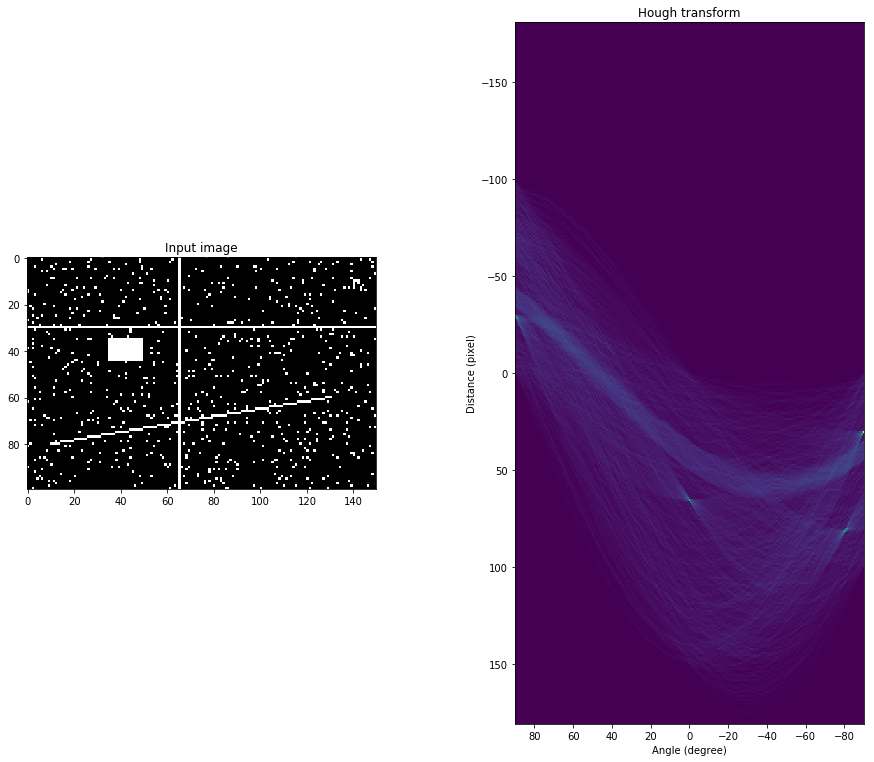

In [15]:
import skimage
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import hough_line
from skimage.draw import line

img = np.zeros((100, 150), dtype=bool)
img[30, :] = 1
img[:, 65] = 1
img[35:45, 35:50] = 1
rr, cc = line(60, 130, 80, 10)
img[rr, cc] = 1
img += np.random.random(img.shape) > 0.95

theta = np.linspace(-np.pi/2, np.pi/2, 360)
hspace, angles, dists = hough_line(img, theta)

#hspace, angles, dists = hough_line(img)
                                   
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)

plt.imshow(img, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(1, 2, 2)
plt.imshow(hspace, 
#            cmap=plt.cm.bone,
           extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]),
                   dists[-1], dists[0]))
plt.title('Hough transform')
plt.xlabel('Angle (degree)')
plt.ylabel('Distance (pixel)')

plt.subplots_adjust(wspace=0.4)
plt.show()

In [3]:
print(hspace.size, angles.size, dists.size)

130320 360 362


In [4]:
lhspace, langles, ldists = skimage.transform.hough_line_peaks(hspace, angles, dists)
print(lhspace)
print(langles)
print(ldists)

[150 100  90]
[1.57079633 0.00437548 1.41327915]
[30.58448753 65.68144044 80.72299169]


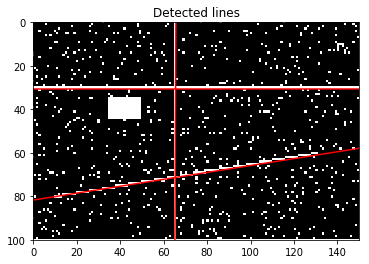

In [16]:
plt.imshow(img, cmap=plt.cm.gray)
rows, cols = img.shape
for _, angle, dist in zip(lhspace, langles, ldists):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')
plt.show()

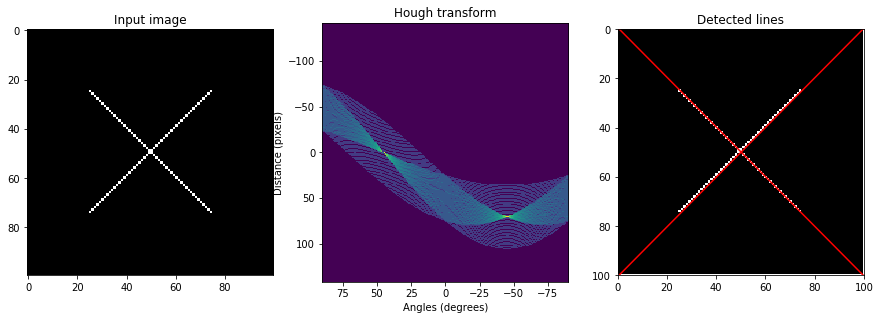

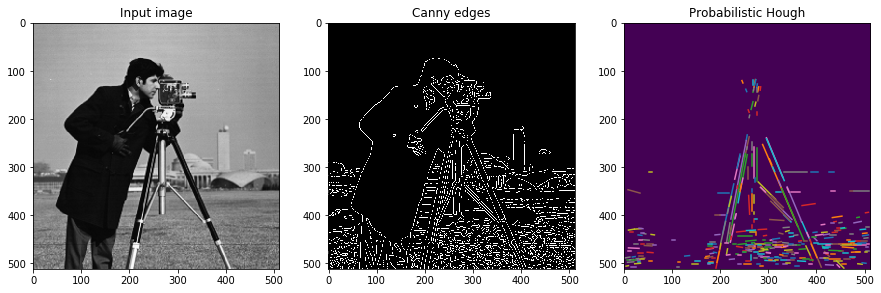

In [6]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Construct test image

image = np.zeros((100, 100))


# Classic straight-line Hough transform

idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

h, theta, d = hough_line(image)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(image, 
           cmap=plt.cm.gray
          )
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
#            cmap=plt.cm.gray, 
           aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')

# Line finding, using the Probabilistic Hough Transform

image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=100, line_length=5, line_gap=3)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(edges, 
           cmap=plt.cm.gray
          )
plt.title('Canny edges')

plt.subplot(133)
plt.imshow(edges * 0)

for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

plt.title('Probabilistic Hough')
plt.axis('image')
plt.show()

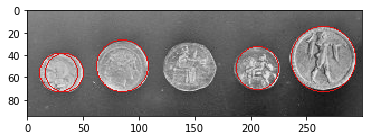

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, feature, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = img_as_ubyte(data.coins()[0:95, 70:370])
edges = feature.canny(image, sigma=3, low_threshold=10, high_threshold=50)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

# Detect two radii
hough_radii = np.arange(15, 30, 2)
hough_res = hough_circle(edges, hough_radii)

centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract two circles
    peaks = peak_local_max(h, num_peaks=2)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius, radius])

# Draw the most prominent 5 circles
image = color.gray2rgb(image)
for idx in np.argsort(accums)[::-1][:5]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)


plt.show()

c:\python36\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
c:\python36\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


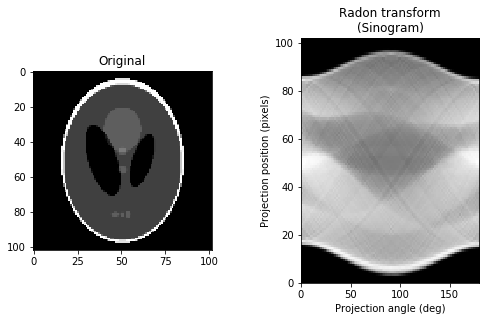

In [8]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, rescale

image = imread("http://www.damtp.cam.ac.uk/user/cbs31/webpage_tvdode/phantom.png", as_grey=True)
image = rescale(image, scale=0.4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.subplots_adjust(hspace=0.4, wspace=0.5)
plt.show()

FBP rms reconstruction error: 0.0547


c:\python36\lib\site-packages\matplotlib\axes\_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


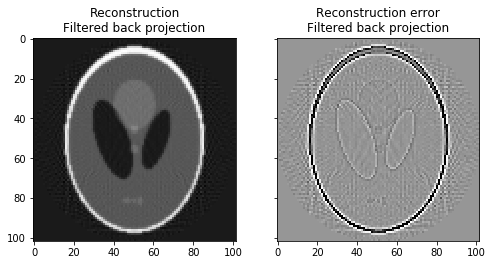

In [9]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

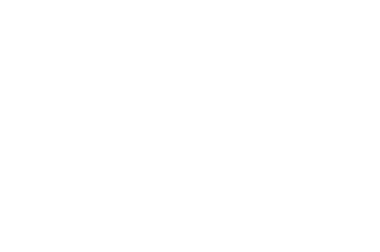

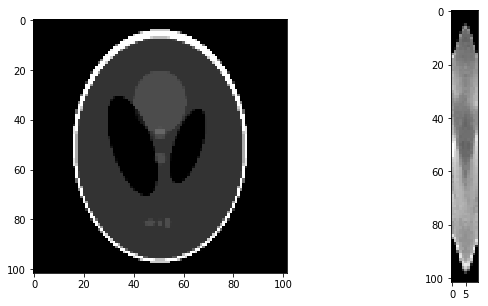

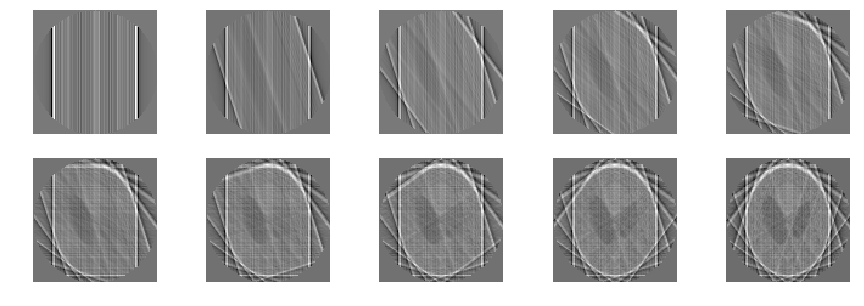

In [10]:
kolik = 10
theta = np.linspace(0., 180., kolik , endpoint=False)
# theta = [0, 45, 90]
sinogram = radon(image, theta=theta, circle=True)
reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)

plt.axis('off')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image, cmap='gray')
ax2.imshow(sinogram, cmap='gray')
plt.figure(figsize=(15,5))
plt.axis('off')
for i in range(1, kolik+1):
    plt.subplot(2,kolik / 2,i)
    plt.axis('off')
    reconstruction_fbp = iradon(sinogram[:,:i], theta=theta[:i], circle=True)
    

    plt.imshow(reconstruction_fbp, cmap='gray')